# Proyek Machine Learning - Prediksi Harga Rumah Pakistan

## Import Library
Melakukan import library yang dibutuhkan untuk keseluruhan proyek.

In [1]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from scipy.stats import randint
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

## Data Loading

Dataset = [Paris Housing Price Prediction](https://www.kaggle.com/datasets/mssmartypants/paris-housing-price-prediction)

Dataset diunduh dari Kaggle, Dataset ini memuat informasi mengenai harga rumah di lingkungan perkotaan - Paris. Dataset berisi fitur ).

In [3]:
# Load csv dari folder data dan tampilkan
df = pd.read_csv('ParisHousing.csv')

# Cek beberapa baris pertama data
print("Dimensi dataset:", df.shape)
df.head()

Dimensi dataset: (10000, 17)


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0


### Deskripsi Dataset
Berdasarkan informasi dari sumber dataset, berikut adalah penjelasan untuk masing-masing kolom:

|      **Fitur**      |                              **Deskripsi**                             |
| :-----------------: | :--------------------------------------------------------------------: |
|    `squareMeters`   |                Luas bangunan rumah dalam meter persegi.                |
|   `numberOfRooms`   |      Jumlah total ruangan (termasuk kamar tidur, ruang tamu, dll).     |
|      `hasYard`      |           Apakah rumah memiliki halaman (1 = ya, 0 = tidak).           |
|      `hasPool`      |         Apakah rumah memiliki kolam renang (1 = ya, 0 = tidak).        |
|       `floors`      |                        Jumlah lantai pada rumah.                       |
|      `cityCode`     |       Kode numerik untuk menunjukkan wilayah administratif/kota.       |
|   `cityPartRange`   | Rentang lokasi rumah dalam bagian kota (misalnya, pusat vs pinggiran). |
|   `numPrevOwners`   |             Jumlah pemilik sebelumnya dari rumah tersebut.             |
|        `made`       |                     Tahun rumah tersebut dibangun.                     |
|     `isNewBuilt`    |        Apakah rumah merupakan bangunan baru (1 = ya, 0 = tidak).       |
| `hasStormProtector` |       Apakah rumah memiliki pelindung badai (1 = ya, 0 = tidak).       |
|      `basement`     |      Apakah rumah memiliki ruang bawah tanah (1 = ya, 0 = tidak).      |
|       `attic`       |            Apakah rumah memiliki loteng (1 = ya, 0 = tidak).           |
|       `garage`      |            Apakah rumah memiliki garasi (1 = ya, 0 = tidak).           |
|   `hasStorageRoom`  |  Apakah rumah memiliki ruang penyimpanan tambahan (1 = ya, 0 = tidak). |
|    `hasGuestRoom`   |          Apakah rumah memiliki kamar tamu (1 = ya, 0 = tidak).         |
|       `price`       |     Harga rumah dalam satuan mata uang tertentu (target variabel).     |

## Eksplorasi Data Awal (EDA)
Mari kita lakukan eksplorasi data untuk memahami karakteristiknya:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   squareMeters       10000 non-null  int64  
 1   numberOfRooms      10000 non-null  int64  
 2   hasYard            10000 non-null  int64  
 3   hasPool            10000 non-null  int64  
 4   floors             10000 non-null  int64  
 5   cityCode           10000 non-null  int64  
 6   cityPartRange      10000 non-null  int64  
 7   numPrevOwners      10000 non-null  int64  
 8   made               10000 non-null  int64  
 9   isNewBuilt         10000 non-null  int64  
 10  hasStormProtector  10000 non-null  int64  
 11  basement           10000 non-null  int64  
 12  attic              10000 non-null  int64  
 13  garage             10000 non-null  int64  
 14  hasStorageRoom     10000 non-null  int64  
 15  hasGuestRoom       10000 non-null  int64  
 16  price              1000

In [5]:
df.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04
mean,49870.13120,50.358400,0.508700,0.496800,50.276300,50225.486100,5.510100,5.521700,2005.48850,0.499100,0.499900,5033.103900,5028.01060,553.12120,0.503000,4.99460,4.993448e+06
std,28774.37535,28.816696,0.499949,0.500015,28.889171,29006.675799,2.872024,2.856667,9.30809,0.500024,0.500025,2876.729545,2894.33221,262.05017,0.500016,3.17641,2.877424e+06
min,89.00000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.00000,0.000000,0.000000,0.000000,1.00000,100.00000,0.000000,0.00000,1.031350e+04
25%,25098.50000,25.000000,0.000000,0.000000,25.000000,24693.750000,3.000000,3.000000,1997.00000,0.000000,0.000000,2559.750000,2512.00000,327.75000,0.000000,2.00000,2.516402e+06
50%,50105.50000,50.000000,1.000000,0.000000,50.000000,50693.000000,5.000000,5.000000,2005.50000,0.000000,0.000000,5092.500000,5045.00000,554.00000,1.000000,5.00000,5.016180e+06
75%,74609.75000,75.000000,1.000000,1.000000,76.000000,75683.250000,8.000000,8.000000,2014.00000,1.000000,1.000000,7511.250000,7540.50000,777.25000,1.000000,8.00000,7.469092e+06
max,99999.00000,100.000000,1.000000,1.000000,100.000000,99953.000000,10.000000,10.000000,2021.00000,1.000000,1.000000,10000.000000,10000.00000,1000.00000,1.000000,10.00000,1.000677e+07


In [6]:
# Melakukan cek terhadap kolom mana saja yang memiliki value Null
columns_with_nan = df.columns[df.isnull().any()].tolist()

# Membuat DataFrame untuk menampilkan kolom yang memiliki nilai null beserta tipe datanya
nan_info = pd.DataFrame({
    'Tipe Data': df[columns_with_nan].dtypes,
    'Jumlah Null': df[columns_with_nan].isnull().sum()
})

print("Kolom yang memiliki nilai Null beserta tipe datanya:")
print(nan_info)

Kolom yang memiliki nilai Null beserta tipe datanya:
Empty DataFrame
Columns: [Tipe Data, Jumlah Null]
Index: []


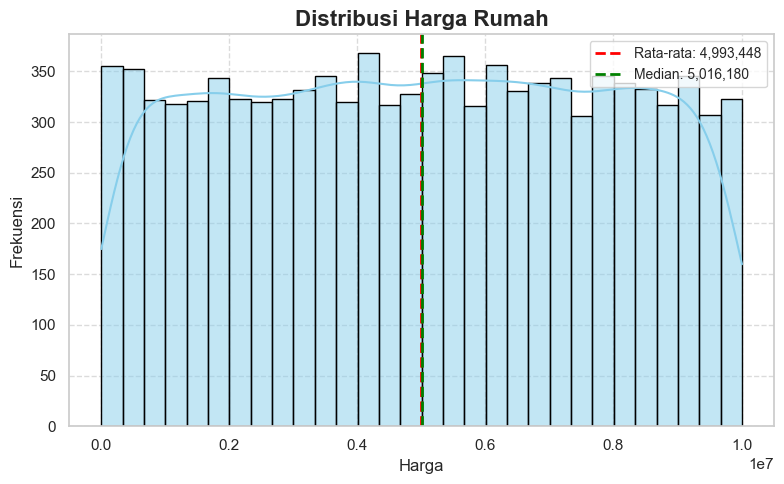

In [15]:
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

# Histogram dengan KDE
sns.histplot(df['price'], kde=True, bins=30, color='skyblue', edgecolor='black')

# Judul dan Label
plt.title('Distribusi Harga Rumah', fontsize=16, fontweight='bold')
plt.xlabel('Harga', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)

# Garis rata-rata dan median
mean_price = df['price'].mean()
median_price = df['price'].median()
plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Rata-rata: {mean_price:,.0f}')
plt.axvline(median_price, color='green', linestyle='--', linewidth=2, label=f'Median: {median_price:,.0f}')

# Tambahkan legenda dan grid
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Output kode di atas memberikan informasi :
* Dataset tidak memiliki outliers

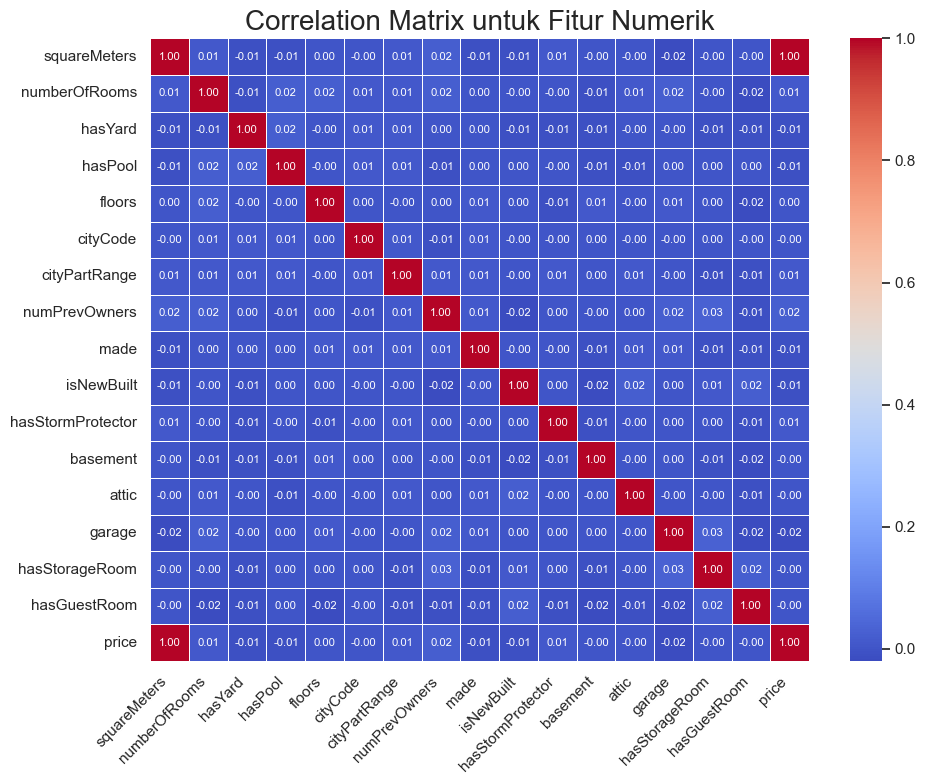

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumsikan df sudah berisi dataset
plt.figure(figsize=(10, 8))

# Pilih hanya kolom numerik
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Hitung korelasi dan bulatkan dua desimal
correlation_matrix = numeric_df.corr().round(2)

# Plot heatmap
sns.heatmap(
    data=correlation_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=0.5,
    fmt=".2f",
    annot_kws={"size": 8}
)

plt.title("Correlation Matrix untuk Fitur Numerik", size=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Dari eksplorasi data di atas, kita dapat menyimpulkan beberapa hal:
1. Dataset berisi 86464 sampel dengan 7 fitur dan 1 target.
2. Tidak terdapat missing values pada dataset.
3. Distribusi harga rumah bersifat right-skewed (skewed to the right / positif skewed).
4. Fitur yang paling kuat korelasinya dengan harga (target) adalah baths (jumlah kamar mandi)
5. Antara baths dan bedrooms memiliki korelasi paling kuat yakni 0.85

## Data Preparation

Pada bagian ini kita akan melakukan persiapan data, yaitu:
* Pembagian data menjadi fitur (X) dan target (y)
* Pembagian data menjadi set pelatihan dan penujian
* Penskalaan fitur numerik

In [20]:
# Membagi dataset menjadi fitur dan target. Target merupakan fitur price. Pembagian dataset dengan perbandingan 80:20.
X = df.drop('price', axis=1)
y = df['price']

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Ukuran set pelatihan: {X_train.shape[0]} sampel")
print(f"Ukuran set pengujian: {X_test.shape[0]} sampel")

Ukuran set pelatihan: 8000 sampel
Ukuran set pengujian: 2000 sampel


In [38]:
#Melakukan standarisasi terhadap fitur numerik pada data train
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train.loc[:, numerical_features])
X_train[numerical_features].head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
9254,1.118998,0.222798,-1.014607,1.006521,-1.664664,0.100225,0.514282,-1.578452,-1.669715,-0.994764,-0.998501,0.399467,1.705792,0.706920,1.00025,-0.939629
1561,1.020945,1.298720,-1.014607,-0.993521,0.996310,0.979392,0.514282,0.169170,-1.562381,1.005264,1.001501,0.302882,0.353532,0.729793,-0.99975,-0.623482
1670,0.995487,0.708699,0.985604,1.006521,1.583798,-0.367779,1.557275,1.567268,-1.669715,1.005264,1.001501,-0.179002,-0.994934,-0.844610,1.00025,0.324960
6087,-1.185374,-0.887831,0.985604,-0.993521,0.166916,-1.136450,-1.571703,0.518694,0.154964,-0.994764,1.001501,1.149219,-1.199101,1.175810,1.00025,0.957254
6669,-1.624404,0.292213,-1.014607,-0.993521,1.549240,-0.497615,0.166618,0.169170,-0.167039,1.005264,1.001501,1.621375,0.394917,-0.810301,-0.99975,0.008813


In [39]:
#Melakukan cek terhadap nilai mean dan std
X_train[numerical_features].describe().round(4)

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
count,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000,8000.0000
mean,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,0.0000,0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000
std,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001
min,-1.7330,-1.7208,-1.0146,-0.9935,-1.6992,-1.7414,-1.5717,-1.5785,-1.6697,-0.9948,-0.9985,-1.7515,-1.7319,-1.7176,-0.9998,-1.5719
25%,-0.8600,-0.8531,-1.0146,-0.9935,-0.8698,-0.8689,-0.8764,-0.8794,-0.9184,-0.9948,-0.9985,-0.8603,-0.8698,-0.8599,-0.9998,-0.9396
50%,0.0085,0.0146,0.9856,-0.9935,-0.0059,0.0122,0.1666,-0.1804,0.0476,-0.9948,-0.9985,0.0341,0.0114,-0.0059,-0.9998,0.0088
75%,0.8547,0.8475,0.9856,1.0065,0.8926,0.8737,0.8619,0.8682,0.9063,1.0053,1.0015,0.8620,0.8661,0.8632,1.0003,0.9573
max,1.7641,1.7152,0.9856,1.0065,1.7220,1.7164,1.5573,1.5673,1.6576,1.0053,1.0015,1.7225,1.7165,1.7133,1.0003,1.5895


Standarisasi berhasil dengan melihat nilai mean = 0 dan std = 1.

**Alasan Penggunaan Teknik Preprocessing:** <br>
- **Train-Test Split:** Untuk mengevaluasi performa model pada data baru yang belum pernah dilihat sebelumnya dan memastikan model dapat melakukan generalisasi dengan baik.<br>
- **StandardScaler:** Menyamakan skala semua fitur agar tidak ada fitur yang mendominasi proses pembelajaran dan penting untuk model yang sensitif terhadap skala fitur (misalnya Regresi Linear, SVR).<br>

## Modeling

Pada bagian ini, kita akan mengembangkan dan mengevaluasi beberapa model untuk memprediksi harga rumah. Sesuai dengan solution statement, kita akan membandingkan performa beberapa algoritma:
1. K-Nearest Neighbor
3. Random Forest
4. Gradient Boosting

In [24]:
#Menyiapkan dataframe untuk analisis masing-masing model
models = pd.DataFrame(index=['train_mse', 'test_mse'],
                      columns=['KNN', 'RF', 'GB'])

In [25]:
#Melatih model KNN
knn_model = KNeighborsRegressor(n_neighbors=10)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [26]:
#Melatih model Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=16, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, n_jobs=-1, random_state=42)

In [27]:
#Melatih model Boosting Algorithm
boosting_model = AdaBoostRegressor(learning_rate=0.05, random_state=55)
boosting_model.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.05, random_state=55)

### Evaluation

### Metrik Evaluasi yang Digunakan

1. **Mean Squared Error (MSE)** - Rata-rata dari kuadrat selisih antara nilai prediksi dan nilai aktual. MSE memberikan bobot yang lebih besar pada kesalahan yang besar.
   
   $$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

2. **Root Mean Squared Error (RMSE)** - Akar kuadrat dari MSE. RMSE memiliki satuan yang sama dengan variabel target, sehingga lebih mudah diinterpretasi.
   
   $$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

3. **Mean Absolute Error (MAE)** - Rata-rata dari nilai absolut selisih antara nilai prediksi dan nilai aktual. MAE kurang sensitif terhadap outlier dibandingkan MSE/RMSE.
   
   $$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

4. **R-squared (R²)** - Proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh variabel independen. Nilai R² berkisar antara 0 dan 1, di mana nilai yang lebih tinggi menunjukkan model yang lebih baik.
   
   $$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

   di mana $\bar{y}$ adalah nilai rata-rata dari $y$.

In [42]:
#Melakukan standarisasi terhadap fitur numerik pada data test
numerical_features = ['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom']
scaler = StandardScaler()
scaler.fit(X_test[numerical_features])
X_test[numerical_features] = scaler.transform(X_test.loc[:, numerical_features])
X_test[numerical_features].head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
6252,0.963309,-1.474167,0.971409,-0.994018,0.358999,-0.500510,0.887480,-1.248805,-0.994740,0.988071,0.995012,-0.566180,0.889350,1.276195,0.969466,-1.265798
4684,-0.472941,1.025039,0.971409,1.006018,1.265340,0.272434,-0.864702,-0.896483,1.487389,0.988071,-1.005013,0.230479,1.102761,-1.547585,-1.031496,-0.026187
1731,1.163444,-0.467542,0.971409,-0.994018,-0.233610,1.143523,1.237917,0.512805,-1.426415,-1.012073,0.995012,0.592914,0.346246,0.493517,0.969466,0.593619
4742,0.444846,-0.675810,0.971409,1.006018,0.149843,0.118158,-0.163829,-0.191839,-1.426415,0.988071,-1.005013,1.660354,0.382801,-0.147205,0.969466,-1.575700
4521,0.456368,1.372151,0.971409,1.006018,0.603014,-1.533019,0.537044,-1.248805,1.487389,-1.012073,-1.005013,-1.063483,1.121213,-0.262305,-1.031496,1.523327


In [43]:
# Fungsi evaluasi
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, result_df):
    # Prediksi
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training metrics
    result_df.loc['train_mse', model_name] = mean_squared_error(y_train, y_train_pred)
    result_df.loc['train_rmse', model_name] = np.sqrt(mean_squared_error(y_train, y_train_pred))
    result_df.loc['train_mae', model_name] = mean_absolute_error(y_train, y_train_pred)
    result_df.loc['train_r2', model_name] = r2_score(y_train, y_train_pred)

    # Testing metrics
    result_df.loc['test_mse', model_name] = mean_squared_error(y_test, y_test_pred)
    result_df.loc['test_rmse', model_name] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    result_df.loc['test_mae', model_name] = mean_absolute_error(y_test, y_test_pred)
    result_df.loc['test_r2', model_name] = r2_score(y_test, y_test_pred)

    return result_df

# Inisialisasi DataFrame kosong
result_df = pd.DataFrame()

result_df = evaluate_model(knn_model, X_train, y_train, X_test, y_test, 'KNN', result_df)
result_df = evaluate_model(rf_model, X_train, y_train, X_test, y_test, 'RF', result_df)
result_df = evaluate_model(boosting_model, X_train, y_train, X_test, y_test, 'Boosting', result_df)

# Tampilkan hasil
print(result_df)


                     KNN            RF      Boosting
train_mse   1.209576e+12  2.101126e+06  1.277552e+11
train_rmse  1.099807e+06  1.449526e+03  3.574285e+05
train_mae   9.056725e+05  1.152520e+03  3.099350e+05
train_r2    8.516664e-01  9.999997e-01  9.843330e-01
test_mse    1.718531e+12  3.239738e+10  1.542182e+11
test_rmse   1.310928e+06  1.799927e+05  3.927063e+05
test_mae    1.086788e+06  1.502514e+05  3.299662e+05
test_r2     8.037928e-01  9.963011e-01  9.823927e-01


                     KNN            RF      Boosting
train_mse   1.209576e+12  2.101126e+06  1.277552e+11
train_rmse  1.099807e+06  1.449526e+03  3.574285e+05
train_mae   9.056725e+05  1.152520e+03  3.099350e+05
train_r2    8.516664e-01  9.999997e-01  9.843330e-01
test_mse    1.718531e+12  3.239738e+10  1.542182e+11
test_rmse   1.310928e+06  1.799927e+05  3.927063e+05
test_mae    1.086788e+06  1.502514e+05  3.299662e+05
test_r2     8.037928e-01  9.963011e-01  9.823927e-01


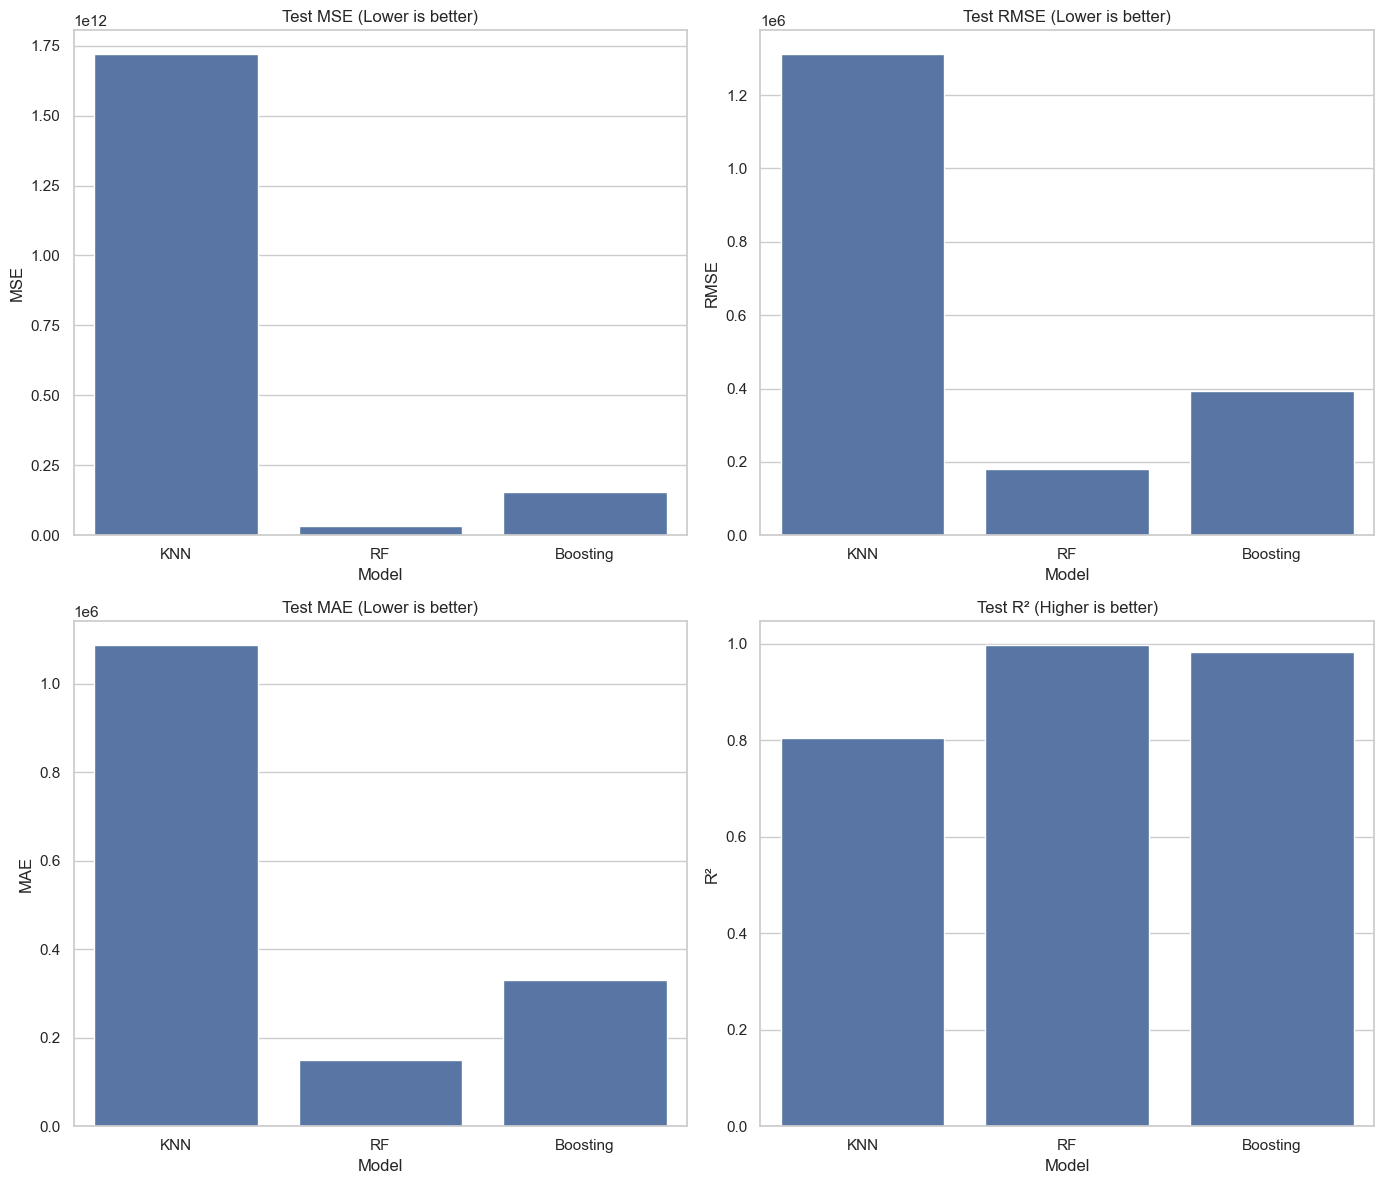

In [45]:
result_df = evaluate_model(knn_model, X_train, y_train, X_test, y_test, 'KNN', result_df)
result_df = evaluate_model(rf_model, X_train, y_train, X_test, y_test, 'RF', result_df)
result_df = evaluate_model(boosting_model, X_train, y_train, X_test, y_test, 'Boosting', result_df)

print(result_df)

# Transpose dan reset index untuk visualisasi
result_plot_df = result_df.T.reset_index().rename(columns={'index': 'Model'})

# Plot
plt.figure(figsize=(14, 12))

# Barplot untuk setiap metrik
metrics = ['test_mse', 'test_rmse', 'test_mae', 'test_r2']
titles = ['Test MSE (Lower is better)', 'Test RMSE (Lower is better)', 'Test MAE (Lower is better)', 'Test R² (Higher is better)']
ylabels = ['MSE', 'RMSE', 'MAE', 'R²']

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    sns.barplot(x='Model', y=metric, data=result_plot_df)
    plt.title(titles[i], fontsize=12)
    plt.ylabel(ylabels[i])

plt.tight_layout()
plt.show()


In [46]:
#### Melakukan tunning pada RF
# Definisikan parameter grid
param_dist = {
    'n_estimators': randint(50, 300),         # Jumlah pohon
    'max_depth': randint(5, 30),              # Kedalaman maksimal pohon
    'min_samples_split': randint(2, 10),      # Min sampel untuk split internal
    'min_samples_leaf': randint(1, 10),       # Min sampel di daun
    'max_features': ['auto', 'sqrt', 'log2']  # Fitur yang digunakan di tiap split
}

# Inisialisasi model
rf = RandomForestRegressor(random_state=42)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,                  # Jumlah kombinasi acak yang dicoba
    cv=3,                       # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Jalankan tuning
random_search.fit(X_train, y_train)

# Lihat hasil terbaik
print("Best Parameters:", random_search.best_params_)
print("Best Score (neg MSE):", random_search.best_score_)

# Model terbaik setelah tuning
best_rf_model = random_search.best_estimator_


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'max_depth': 26, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 276}
Best Score (neg MSE): -132091854675.84221


In [47]:
# Evaluasi dan simpan metrik ke result_df
result_df = evaluate_model(best_rf_model, X_train, y_train, X_test, y_test, 'RF_Tuned', result_df)

rf_before_tuning = result_df['RF']
rf_after_tuning = result_df['RF_Tuned']

# Buat DataFrame perbandingan
comparison = pd.DataFrame({
    'Sebelum Tuning': rf_before_tuning,
    'Setelah Tuning': rf_after_tuning
})

# Cetak hasil
print("Perbandingan performa Random Forest sebelum dan sesudah tuning:")
print(comparison)


Perbandingan performa Random Forest sebelum dan sesudah tuning:
            Sebelum Tuning  Setelah Tuning
train_mse     2.101126e+06    3.384314e+10
train_rmse    1.449526e+03    1.839651e+05
train_mae     1.152520e+03    1.355925e+05
train_r2      9.999997e-01    9.958497e-01
test_mse      3.239738e+10    1.560090e+11
test_rmse     1.799927e+05    3.949797e+05
test_mae      1.502514e+05    3.120134e+05
test_r2       9.963011e-01    9.821882e-01


In [54]:
print("RF Setelah Tuning")
print(rf_after_tuning)

RF Setelah Tuning
train_mse     3.384314e+10
train_rmse    1.839651e+05
train_mae     1.355925e+05
train_r2      9.958497e-01
test_mse      1.560090e+11
test_rmse     3.949797e+05
test_mae      3.120134e+05
test_r2       9.821882e-01
Name: RF_Tuned, dtype: float64


In [ ]:
### Perbandingan Prediksi vs Nilai Aktual

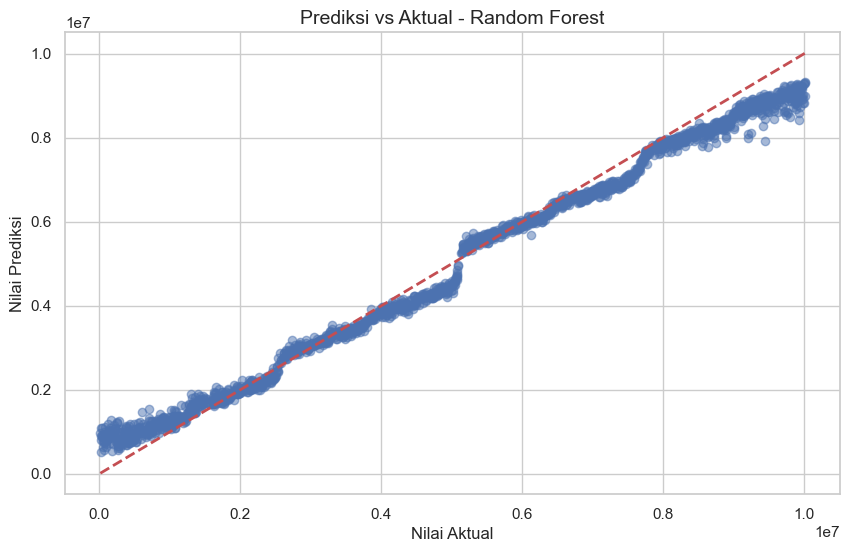

In [48]:
# Prediksi pada data test
y_pred_best = best_rf_model.predict(X_test)

# Visualisasi perbandingan prediksi vs aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Prediksi vs Aktual - Random Forest', fontsize=14)
plt.xlabel('Nilai Aktual')
plt.ylabel('Nilai Prediksi')
plt.grid(True)
plt.show()

### Menyimpan model

In [51]:
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# Simpan model terbaik menggunakan joblib
model_path = 'D:/submission-predictive-analytics/models/random_forest_model.pkl'
joblib.dump(best_rf_model, model_path)
print(f"Model berhasil disimpan di {os.path.abspath(model_path)}")

Model berhasil disimpan di D:\submission-predictive-analytics\models\random_forest_model.pkl


In [52]:
# Contoh cara memuat dan menggunakan model
loaded_model = joblib.load(model_path)

# Sampel data untuk pengujian
sample_data = X_test.iloc[:5]  # Mengambil 5 sampel pertama dari data test

# Prediksi menggunakan model yang dimuat
sample_predictions = loaded_model.predict(sample_data)

# Bandingkan dengan data aktual
comparison = pd.DataFrame({
    'Actual': y_test.iloc[:5].values,
    'Predicted': sample_predictions,
    'Difference': abs(y_test.iloc[:5].values - sample_predictions),
    'Error (%)': (abs(y_test.iloc[:5].values - sample_predictions) / y_test.iloc[:5].values) * 100
})
comparison['Actual'] = comparison['Actual'].map('${:,.2f}'.format)
comparison['Predicted'] = comparison['Predicted'].map('${:,.2f}'.format)
comparison['Difference'] = comparison['Difference'].map('${:,.2f}'.format)
comparison['Error (%)'] = comparison['Error (%)'].map('{:.2f}%'.format)

comparison

,Actual,Predicted,Difference,Error (%)
0,"$7,964,369.60","$7,716,843.27","$247,526.33",3.11%
1,"$3,713,548.90","$3,481,553.25","$231,995.65",6.25%
2,"$8,553,019.20","$8,242,450.24","$310,568.96",3.63%
3,"$6,428,666.20","$6,376,233.15","$52,433.05",0.82%
4,"$6,465,184.90","$6,308,752.31","$156,432.59",2.42%
